<a href="https://colab.research.google.com/github/naevs/AI-in-Finance/blob/main/Q1(Above_Risk_Free_Rate).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and data loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from hyperopt import hp, fmin, atpe, tpe, STATUS_OK, Trials
from keras.optimizers import Adam
#pip install PyPortfolioOpt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage, sample_cov
from pypfopt.expected_returns import returns_from_prices
from pypfopt import objective_functions
from pypfopt import risk_models, expected_returns
# Fetch daily data for 4 years
symbols=['AAPL', 'AMZN','GOOGL','META', 'MCD', 'GM', 'TSLA','PFE']
from datetime import datetime, timedelta

start_date = '2017-1-1'
end_date = '2023-12-31'
df = yf.download(symbols, start_date, end_date)['Adj Close']

# Download Risk-Free Rate data
rf_rate_symbol = '^IRX'
rf_rate_data = yf.download(rf_rate_symbol, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  8 of 8 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
dfa = df[df.index <= pd.Timestamp('2023-01-01')]

# Question 1a

Covariance Matrix:
 Ticker      AAPL      AMZN        GM     GOOGL       MCD      META       PFE  \
Ticker                                                                         
AAPL    0.001600  0.000916  0.000922  0.000882  0.000537  0.000944  0.000418   
AMZN    0.000916  0.001886  0.000640  0.001033  0.000353  0.001123  0.000303   
GM      0.000922  0.000640  0.003185  0.000949  0.000955  0.001023  0.000433   
GOOGL   0.000882  0.001033  0.000949  0.001383  0.000468  0.001094  0.000398   
MCD     0.000537  0.000353  0.000955  0.000468  0.000813  0.000418  0.000314   
META    0.000944  0.001123  0.001023  0.001094  0.000418  0.002566  0.000531   
PFE     0.000418  0.000303  0.000433  0.000398  0.000314  0.000531  0.001133   
TSLA    0.001556  0.001502  0.001937  0.001229  0.000882  0.001095  0.000542   

Ticker      TSLA  
Ticker            
AAPL    0.001556  
AMZN    0.001502  
GM      0.001937  
GOOGL   0.001229  
MCD     0.000882  
META    0.001095  
PFE     0.000542  
TSLA    

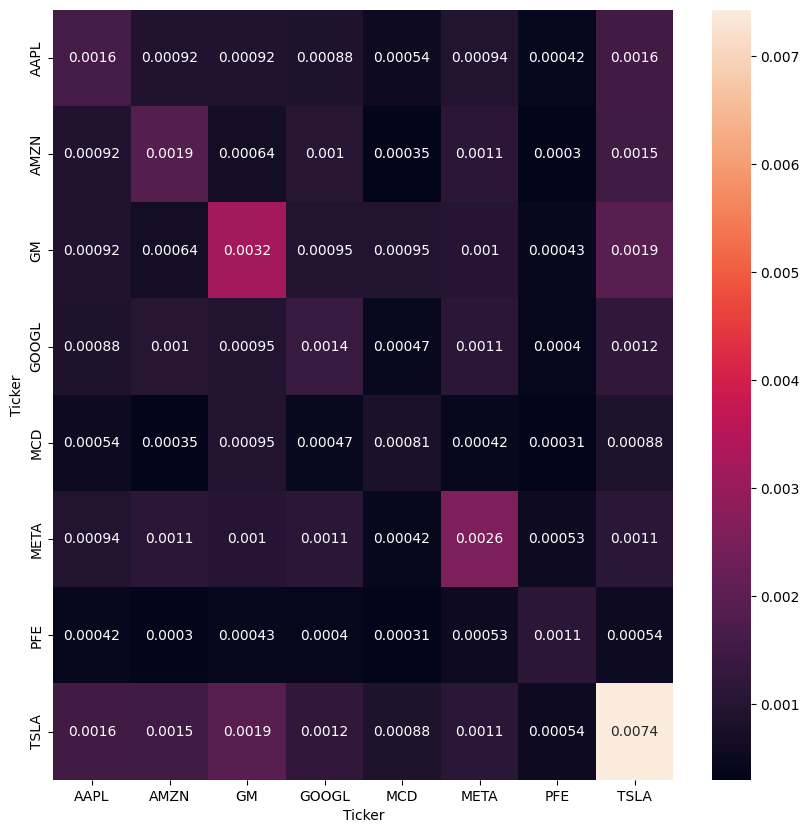

In [ ]:
# Calculate weekly returns
df_weekly_returns = dfa.resample('W').last().pct_change().dropna()

# Estimate the covariance matrix
covariance_matrix = df_weekly_returns.cov()
print("Covariance Matrix:\n", covariance_matrix)

plt.figure(figsize=(10, 10))
sns.heatmap(covariance_matrix, annot=True)
plt.show()

#Question 1b

In [ ]:
def prepare_data(stock_data, start_date, end_date):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(stock_data.values.reshape(-1, 1))

    forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
    forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')

    data_train = data_scaled[:forecast_start_idx - sequence_length]
    data_test = data_scaled[forecast_start_idx - sequence_length:forecast_end_idx + 1]

    train_generator = TimeseriesGenerator(data_train, data_train, length=sequence_length, batch_size=1)
    test_generator = TimeseriesGenerator(data_test, data_test, length=sequence_length, batch_size=1)

    X_train, y_train = zip(*[gen for gen in train_generator])
    X_test, y_test = zip(*[gen for gen in test_generator])

    X_train = np.squeeze(np.array(X_train), axis=1)
    y_train = np.squeeze(np.array(y_train), axis=1)
    X_test = np.squeeze(np.array(X_test), axis=1)
    y_test = np.squeeze(np.array(y_test), axis=1)

    return X_train, y_train, X_test, y_test, scaler


sequence_length = 60
X_train, y_train, X_test, y_test, scaler = prepare_data(df, start_date='2022-12-23', end_date='2022-12-31')

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1385, 60, 1)
y_train shape: (1385, 1)
X_test shape: (5, 60, 1)
y_test shape: (5, 1)


<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


In [ ]:
def lstm_model(params):
    model = Sequential()
    model.add(LSTM(units=int(params['units']), input_shape=(60, 1), return_sequences=params['num_lstm_layers'] > 1))
    model.add(Dropout(params['dropout_rate']))

    for i in range(1, params['num_lstm_layers']):
        if i == params['num_lstm_layers'] - 1:
            model.add(LSTM(units=int(params['units']), return_sequences=False))
        else:
            model.add(LSTM(units=int(params['units']), return_sequences=True))
        model.add(Dropout(params['dropout_rate']))

    model.add(Dense(1))
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=0)
    model.fit(X_train, y_train, epochs=int(params['epochs']), batch_size=int(params['batch_size']), verbose=0, callbacks=[early_stop])
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return {'loss': mse, 'status': STATUS_OK}

space = {
    'units': hp.choice('units', [50, 100, 150]),
    'num_lstm_layers': hp.choice('num_lstm_layers', [1, 2, 3]),
    'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    'epochs': hp.choice('epochs', [50, 100, 150]),
    'batch_size': hp.choice('batch_size', [16, 32, 64])
}

trials = Trials()
best = fmin(lstm_model, space, algo=tpe.suggest, max_evals=30, trials=trials)

print("Best hyperparameters:", best)

In [ ]:
#Best hyperparameters: {'batch_size': 1, 'dropout_rate': 0.14471559163933534, 'epochs': 2, 'learning_rate': 0.04054946189321238, 'num_lstm_layers': 0, 'units': 1}

#Question 1c

In [ ]:
stock_forecasts = {}
stock_actual = {}

for symbol in symbols:
    print(f"Processing {symbol}")
    stock_data = df[symbol]

    X_train, y_train, X_test, y_test, scaler = prepare_data(stock_data, start_date='2023-1-1', end_date='2023-1-7')

    units = 100
    num_lstm_layers = 1
    dropout_rate = 0.14471559163933534
    learning_rate = 0.04054946189321238
    epochs = 150
    batch_size = 32

    model = Sequential()
    model.add(LSTM(units, input_shape=(sequence_length, 1), return_sequences=True))
    model.add(Dropout(dropout_rate))
    if num_lstm_layers > 1:
        for _ in range(1, num_lstm_layers):
            model.add(LSTM(units, return_sequences=True))
            model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    model.summary()

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Predict
    predictions_scaled = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions_scaled)

    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
    stock_forecasts[symbol] = predictions[-1]
    stock_actual[symbol] = actual_prices[-1]
    model.reset_states()

Processing AAPL


<ipython-input-40-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-40-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 100)           40800     
                                                                 
 dropout_8 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
44

<ipython-input-40-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-40-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_10 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
44

1/1 [==============================] - 1s 614ms/step


<ipython-input-40-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-40-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Processing GOOGL
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_12 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_13 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_13 (Dropout)        (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________________________

1/1 [==============================] - 1s 587ms/step


<ipython-input-40-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-40-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Processing META
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_14 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_15 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________

<ipython-input-40-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-40-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_16 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_17 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_17 (Dropout)        (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
44

<ipython-input-40-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-40-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_18 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_19 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_19 (Dropout)        (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
44

<ipython-input-40-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-40-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_20 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_21 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_21 (Dropout)        (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
4

<ipython-input-40-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-40-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_22 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_23 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_23 (Dropout)        (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
4

In [ ]:
stock_actual

{'AAPL': array([128.73522949]),
 'AMZN': array([86.08000183]),
 'GOOGL': array([87.33999634]),
 'META': array([129.88220215]),
 'MCD': array([262.01358032]),
 'GM': array([35.42432404]),
 'TSLA': array([113.05999756]),
 'PFE': array([47.9877739])}

In [ ]:
stock_forecasts

{'AAPL': array([142.33076], dtype=float32),
 'AMZN': array([85.41302], dtype=float32),
 'GOOGL': array([106.175095], dtype=float32),
 'META': array([192.0756], dtype=float32),
 'MCD': array([250.08617], dtype=float32),
 'GM': array([35.615482], dtype=float32),
 'TSLA': array([175.5682], dtype=float32),
 'PFE': array([46.56995], dtype=float32)}

In [ ]:
expected_returns = {symbol: (stock_forecasts[symbol][0] - stock_actual[symbol][0]) / stock_actual[symbol][0] for symbol in stock_forecasts}
print("Expected Returns:")
for symbol, expected_return in expected_returns.items():
    print(f"{symbol}: {expected_return:.4f}")

Expected Returns:
AAPL: 0.1056
AMZN: -0.0077
GOOGL: 0.2157
META: 0.4788
MCD: -0.0455
GM: 0.0054
TSLA: 0.5529
PFE: -0.0295


In [ ]:
weekly_rf_rate = rf_rate_data['2023-01-03']
weekly_rf_rate = weekly_rf_rate/100
weekly_rf_rate = weekly_rf_rate.mean()
weekly_rf_rate

0.04255000114440918

In [ ]:
dfa = df[df.index <= pd.Timestamp('2022-12-31')]
df_weekly = dfa.resample('W').last()
df_weekly_returns = df_weekly.pct_change().dropna()
cov_matrix = df_weekly_returns.cov()

expected_returns_list = pd.Series({
    'AAPL': 0.1056,
    'AMZN': -0.0077,
    'GM': 0.0054,
    'GOOGL': 0.2157,
    'MCD': -0.0455,
    'META': 0.4788,
    'PFE': -0.0295,
    'TSLA': 0.5529,
})
ef = EfficientFrontier(expected_returns_list, cov_matrix, weight_bounds=(0, 1))
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
cleaned_weights = ef.max_sharpe(risk_free_rate=weekly_rf_rate)

cleaned_weights = ef.clean_weights()

print("Optimized Portfolio Weights:")
print(cleaned_weights)

ef.portfolio_performance(verbose=True, risk_free_rate=weekly_rf_rate)

Optimized Portfolio Weights:
OrderedDict([('AAPL', 0.04526), ('AMZN', 0.0), ('GM', 0.0), ('GOOGL', 0.14611), ('MCD', 0.0), ('META', 0.38148), ('PFE', 0.0), ('TSLA', 0.42715)])
Expected annual return: 45.5%
Annual volatility: 5.0%
Sharpe Ratio: 8.25


/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


(0.4551190457884588, 0.04998775965215308, 8.253401382957946)

# Question 1d

In [ ]:
initial_prices = {symbol: df[symbol]['2022-12-30'] for symbol in symbols}
actual_returns = {symbol: (stock_actual[symbol][0] - initial_prices[symbol]) / initial_prices[symbol] for symbol in symbols}
portfolio_actual_return = sum(cleaned_weights[symbol] * actual_returns[symbol] for symbol in symbols)
print(f"Portfolio's actual rate of return for the first week of January 2023: {portfolio_actual_return:.4f}")

Portfolio's actual rate of return for the first week of January 2023: -0.0060


In [ ]:
equal_weight_return = sum(actual_returns.values()) / len(actual_returns)
print(f"Equally weighted portfolio's rate of return for the first week: {equal_weight_return:.4f}")

Equally weighted portfolio's rate of return for the first week: 0.0118


# Question 1e

In [ ]:
symbols = ['AAPL', 'AMZN', 'GM', 'GOOGL', 'MCD', 'META', 'PFE', 'TSLA']
portfolio_performance_records = []
equally_weighted_performance_records = []
error_dates = []

def record_performance(date, portfolio_return, equally_weighted_return, error_occurred):
    portfolio_performance_records.append((date, portfolio_return, error_occurred))
    equally_weighted_performance_records.append((date, equally_weighted_return, error_occurred))

start_date = datetime(2023, 1, 2)
end_date = datetime(2023, 12, 31)

def run_weekly_forecasts(start_date, end_date):
    current_date = start_date
    while current_date <= end_date:
        error_occurred = False
        if current_date.strftime('%Y-%m-%d') in rf_rate_data.index:
            weekly_rf_rate = rf_rate_data.loc[current_date.strftime('%Y-%m-%d')] / 100
            weekly_rf_rate = weekly_rf_rate.mean()
        else:
            weekly_rf_rate = rf_rate_data['2023']/ 100
            weekly_rf_rate = weekly_rf_rate.mean()

        expected_returns = {}
        actual_returns = {}

        for symbol in symbols:
            stock_data = df[symbol]

            X_train, y_train, X_test, y_test, scaler = prepare_data(stock_data, current_date, current_date + timedelta(weeks=1))

            units = 100
            num_lstm_layers = 1
            dropout_rate = 0.14471559163933534
            learning_rate = 0.04054946189321238
            epochs = 2
            batch_size = 32

            model = Sequential()
            model.add(LSTM(units, input_shape=(sequence_length, 1), return_sequences=True))
            model.add(Dropout(dropout_rate))
            if num_lstm_layers > 1:
                for _ in range(1, num_lstm_layers):
                    model.add(LSTM(units, return_sequences=True))
                    model.add(Dropout(dropout_rate))
            model.add(LSTM(units, return_sequences=False))
            model.add(Dropout(dropout_rate))
            model.add(Dense(1))

            optimizer = Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer, loss='mean_squared_error')

            model.summary()

            model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

            predictions_scaled = model.predict(X_test)
            predictions = scaler.inverse_transform(predictions_scaled)[-1]
            actual = scaler.inverse_transform(y_test.reshape(-1, 1))[-1]

            expected_return = (predictions - actual) / actual

            expected_returns[symbol] = expected_return

            actual_returns[symbol] = (actual - scaler.inverse_transform(X_test[-1, -1].reshape(-1, 1))[0]) / scaler.inverse_transform(X_test[-1, -1].reshape(-1, 1))[0]

        df_weekly = df[df.index <= pd.Timestamp(current_date.strftime('%Y-%m-%d'))].resample('W').last()
        df_weekly_returns = df_weekly.pct_change().dropna()
        cov_matrix = df_weekly_returns.cov()
        print('uoutput')
        print(weekly_rf_rate)
        print(expected_returns)
        try:
            ef = EfficientFrontier(pd.Series(expected_returns), cov_matrix, weight_bounds=(0, 1))
            ef.add_objective(objective_functions.L2_reg, gamma=0.1)
            weights = ef.max_sharpe(risk_free_rate=weekly_rf_rate)
            cleaned_weights = ef.clean_weights()
        except Exception as e:
            print(f"Encountered an optimization error on {current_date}: {e}. Opting for an equal weighting strategy.")
            cleaned_weights = {symbol: 1/len(symbols) for symbol in symbols}  # Use equal weighting as fallback
            error_dates.append(current_date)  # Log the date of the error
            error_occurred = True

        optimized_portfolio_return = np.dot(list(cleaned_weights.values()), list(actual_returns.values()))
        equally_weighted_return = np.mean(list(actual_returns.values()))

        record_performance(current_date, optimized_portfolio_return, equally_weighted_return, error_occurred=error_occurred)

        current_date += timedelta(weeks=1)

run_weekly_forecasts(start_date, end_date)

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/44 

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 dropout_2 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/4

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 100)           40800     
                                                                 
 dropout_4 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/4

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 100)           40800     
                                                                 
 dropout_6 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/4

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 100)           40800     
                                                                 
 dropout_8 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/4

1/1 [==============================] - 1s 623ms/step


<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_10 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/4

1/1 [==============================] - 1s 631ms/step


<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_12 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_13 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_13 (Dropout)        (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/4

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_14 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_15 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/4

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_16 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_17 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_17 (Dropout)        (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/4

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_18 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_19 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_19 (Dropout)        (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/4

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_20 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_21 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_21 (Dropout)        (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_22 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_23 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_23 (Dropout)        (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_24 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_25 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_25 (Dropout)        (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_26 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_27 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_27 (Dropout)        (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_28 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_29 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_29 (Dropout)        (None, 100)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_30 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_31 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_31 (Dropout)        (None, 100)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_32 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_33 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_33 (Dropout)        (None, 100)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_34 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_35 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_35 (Dropout)        (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_36 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_37 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_37 (Dropout)        (None, 100)               0         
                                                                 
 dense_18 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_38 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_39 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_39 (Dropout)        (None, 100)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_40 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_41 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_41 (Dropout)        (None, 100)               0         
                                                                 
 dense_20 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_42 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_43 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_43 (Dropout)        (None, 100)               0         
                                                                 
 dense_21 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_44 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_45 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_45 (Dropout)        (None, 100)               0         
                                                                 
 dense_22 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_46 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_47 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_47 (Dropout)        (None, 100)               0         
                                                                 
 dense_23 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_48 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_49 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_49 (Dropout)        (None, 100)               0         
                                                                 
 dense_24 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_50 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_51 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_51 (Dropout)        (None, 100)               0         
                                                                 
 dense_25 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_52 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_53 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_53 (Dropout)        (None, 100)               0         
                                                                 
 dense_26 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_54 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_55 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_55 (Dropout)        (None, 100)               0         
                                                                 
 dense_27 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_56 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_57 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_57 (Dropout)        (None, 100)               0         
                                                                 
 dense_28 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_58 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_59 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_59 (Dropout)        (None, 100)               0         
                                                                 
 dense_29 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_60 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_61 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_61 (Dropout)        (None, 100)               0         
                                                                 
 dense_30 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_62 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_63 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_63 (Dropout)        (None, 100)               0         
                                                                 
 dense_31 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_64 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_65 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_65 (Dropout)        (None, 100)               0         
                                                                 
 dense_32 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_66 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_67 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_67 (Dropout)        (None, 100)               0         
                                                                 
 dense_33 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_68 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_69 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_69 (Dropout)        (None, 100)               0         
                                                                 
 dense_34 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_70 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_71 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_71 (Dropout)        (None, 100)               0         
                                                                 
 dense_35 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_72 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_73 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_73 (Dropout)        (None, 100)               0         
                                                                 
 dense_36 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_74 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_74 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_75 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_75 (Dropout)        (None, 100)               0         
                                                                 
 dense_37 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_76 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_76 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_77 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_77 (Dropout)        (None, 100)               0         
                                                                 
 dense_38 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_78 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_78 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_79 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_79 (Dropout)        (None, 100)               0         
                                                                 
 dense_39 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
44/

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_80 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_80 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_81 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_81 (Dropout)        (None, 100)               0         
                                                                 
 dense_40 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_82 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_82 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_83 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_83 (Dropout)        (None, 100)               0         
                                                                 
 dense_41 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_84 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_84 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_85 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_85 (Dropout)        (None, 100)               0         
                                                                 
 dense_42 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_86 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_86 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_87 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_87 (Dropout)        (None, 100)               0         
                                                                 
 dense_43 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_88 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_88 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_89 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_89 (Dropout)        (None, 100)               0         
                                                                 
 dense_44 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_90 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_90 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_91 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_91 (Dropout)        (None, 100)               0         
                                                                 
 dense_45 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_92 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_92 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_93 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_93 (Dropout)        (None, 100)               0         
                                                                 
 dense_46 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_94 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_94 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_95 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_95 (Dropout)        (None, 100)               0         
                                                                 
 dense_47 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_96 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_96 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_97 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_97 (Dropout)        (None, 100)               0         
                                                                 
 dense_48 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_98 (LSTM)              (None, 60, 100)           40800     
                                                                 
 dropout_98 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_99 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_99 (Dropout)        (None, 100)               0         
                                                                 
 dense_49 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_100 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_100 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_101 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_101 (Dropout)       (None, 100)               0         
                                                                 
 dense_50 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_102 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_102 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_103 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_103 (Dropout)       (None, 100)               0         
                                                                 
 dense_51 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_104 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_104 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_105 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_105 (Dropout)       (None, 100)               0         
                                                                 
 dense_52 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_106 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_106 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_107 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_107 (Dropout)       (None, 100)               0         
                                                                 
 dense_53 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_108 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_108 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_109 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_109 (Dropout)       (None, 100)               0         
                                                                 
 dense_54 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_110 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_110 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_111 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_111 (Dropout)       (None, 100)               0         
                                                                 
 dense_55 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_112 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_112 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_113 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_113 (Dropout)       (None, 100)               0         
                                                                 
 dense_56 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_114 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_114 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_115 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_115 (Dropout)       (None, 100)               0         
                                                                 
 dense_57 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_116 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_116 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_117 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_117 (Dropout)       (None, 100)               0         
                                                                 
 dense_58 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_118 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_118 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_119 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_119 (Dropout)       (None, 100)               0         
                                                                 
 dense_59 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_120 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_120 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_121 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_121 (Dropout)       (None, 100)               0         
                                                                 
 dense_60 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_122 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_122 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_123 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_123 (Dropout)       (None, 100)               0         
                                                                 
 dense_61 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_124 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_124 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_125 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_125 (Dropout)       (None, 100)               0         
                                                                 
 dense_62 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_126 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_126 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_127 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_127 (Dropout)       (None, 100)               0         
                                                                 
 dense_63 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_128 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_128 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_129 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_129 (Dropout)       (None, 100)               0         
                                                                 
 dense_64 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_130 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_130 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_131 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_131 (Dropout)       (None, 100)               0         
                                                                 
 dense_65 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_132 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_132 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_133 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_133 (Dropout)       (None, 100)               0         
                                                                 
 dense_66 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_134 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_134 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_135 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_135 (Dropout)       (None, 100)               0         
                                                                 
 dense_67 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_136 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_136 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_137 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_137 (Dropout)       (None, 100)               0         
                                                                 
 dense_68 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_138 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_138 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_139 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_139 (Dropout)       (None, 100)               0         
                                                                 
 dense_69 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_140 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_140 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_141 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_141 (Dropout)       (None, 100)               0         
                                                                 
 dense_70 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_142 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_142 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_143 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_143 (Dropout)       (None, 100)               0         
                                                                 
 dense_71 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_144 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_144 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_145 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_145 (Dropout)       (None, 100)               0         
                                                                 
 dense_72 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_146 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_146 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_147 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_147 (Dropout)       (None, 100)               0         
                                                                 
 dense_73 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_148 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_148 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_149 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_149 (Dropout)       (None, 100)               0         
                                                                 
 dense_74 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_150 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_150 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_151 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_151 (Dropout)       (None, 100)               0         
                                                                 
 dense_75 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_152 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_152 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_153 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_153 (Dropout)       (None, 100)               0         
                                                                 
 dense_76 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_154 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_154 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_155 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_155 (Dropout)       (None, 100)               0         
                                                                 
 dense_77 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_156 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_156 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_157 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_157 (Dropout)       (None, 100)               0         
                                                                 
 dense_78 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_158 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_158 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_159 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_159 (Dropout)       (None, 100)               0         
                                                                 
 dense_79 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_160 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_160 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_161 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_161 (Dropout)       (None, 100)               0         
                                                                 
 dense_80 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_162 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_162 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_163 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_163 (Dropout)       (None, 100)               0         
                                                                 
 dense_81 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_164 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_164 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_165 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_165 (Dropout)       (None, 100)               0         
                                                                 
 dense_82 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_166 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_166 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_167 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_167 (Dropout)       (None, 100)               0         
                                                                 
 dense_83 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_168 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_168 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_169 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_169 (Dropout)       (None, 100)               0         
                                                                 
 dense_84 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_170 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_170 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_171 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_171 (Dropout)       (None, 100)               0         
                                                                 
 dense_85 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_172 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_172 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_173 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_173 (Dropout)       (None, 100)               0         
                                                                 
 dense_86 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_174 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_174 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_175 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_175 (Dropout)       (None, 100)               0         
                                                                 
 dense_87 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
45/

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_176 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_176 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_177 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_177 (Dropout)       (None, 100)               0         
                                                                 
 dense_88 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_178 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_178 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_179 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_179 (Dropout)       (None, 100)               0         
                                                                 
 dense_89 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_180 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_180 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_181 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_181 (Dropout)       (None, 100)               0         
                                                                 
 dense_90 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_182 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_182 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_183 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_183 (Dropout)       (None, 100)               0         
                                                                 
 dense_91 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_184 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_184 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_185 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_185 (Dropout)       (None, 100)               0         
                                                                 
 dense_92 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_186 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_186 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_187 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_187 (Dropout)       (None, 100)               0         
                                                                 
 dense_93 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_188 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_188 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_189 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_189 (Dropout)       (None, 100)               0         
                                                                 
 dense_94 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_190 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_190 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_191 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_191 (Dropout)       (None, 100)               0         
                                                                 
 dense_95 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46/

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_192 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_192 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_193 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_193 (Dropout)       (None, 100)               0         
                                                                 
 dense_96 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_194 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_194 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_195 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_195 (Dropout)       (None, 100)               0         
                                                                 
 dense_97 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_196 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_196 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_197 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_197 (Dropout)       (None, 100)               0         
                                                                 
 dense_98 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_198 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_198 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_199 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_199 (Dropout)       (None, 100)               0         
                                                                 
 dense_99 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46/

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_200 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_200 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_201 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_201 (Dropout)       (None, 100)               0         
                                                                 
 dense_100 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_202 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_202 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_203 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_203 (Dropout)       (None, 100)               0         
                                                                 
 dense_101 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_204 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_204 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_205 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_205 (Dropout)       (None, 100)               0         
                                                                 
 dense_102 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_206 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_206 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_207 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_207 (Dropout)       (None, 100)               0         
                                                                 
 dense_103 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_208 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_208 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_209 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_209 (Dropout)       (None, 100)               0         
                                                                 
 dense_104 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_105"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_210 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_210 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_211 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_211 (Dropout)       (None, 100)               0         
                                                                 
 dense_105 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_212 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_212 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_213 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_213 (Dropout)       (None, 100)               0         
                                                                 
 dense_106 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_214 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_214 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_215 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_215 (Dropout)       (None, 100)               0         
                                                                 
 dense_107 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_216 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_216 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_217 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_217 (Dropout)       (None, 100)               0         
                                                                 
 dense_108 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_109"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_218 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_218 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_219 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_219 (Dropout)       (None, 100)               0         
                                                                 
 dense_109 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_110"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_220 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_220 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_221 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_221 (Dropout)       (None, 100)               0         
                                                                 
 dense_110 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_111"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_222 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_222 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_223 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_223 (Dropout)       (None, 100)               0         
                                                                 
 dense_111 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_112"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_224 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_224 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_225 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_225 (Dropout)       (None, 100)               0         
                                                                 
 dense_112 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_113"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_226 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_226 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_227 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_227 (Dropout)       (None, 100)               0         
                                                                 
 dense_113 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_114"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_228 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_228 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_229 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_229 (Dropout)       (None, 100)               0         
                                                                 
 dense_114 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_115"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_230 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_230 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_231 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_231 (Dropout)       (None, 100)               0         
                                                                 
 dense_115 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_116"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_232 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_232 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_233 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_233 (Dropout)       (None, 100)               0         
                                                                 
 dense_116 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_117"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_234 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_234 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_235 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_235 (Dropout)       (None, 100)               0         
                                                                 
 dense_117 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_118"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_236 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_236 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_237 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_237 (Dropout)       (None, 100)               0         
                                                                 
 dense_118 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_119"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_238 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_238 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_239 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_239 (Dropout)       (None, 100)               0         
                                                                 
 dense_119 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_240 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_240 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_241 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_241 (Dropout)       (None, 100)               0         
                                                                 
 dense_120 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_242 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_242 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_243 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_243 (Dropout)       (None, 100)               0         
                                                                 
 dense_121 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_122"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_244 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_244 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_245 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_245 (Dropout)       (None, 100)               0         
                                                                 
 dense_122 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_123"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_246 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_246 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_247 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_247 (Dropout)       (None, 100)               0         
                                                                 
 dense_123 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_124"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_248 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_248 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_249 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_249 (Dropout)       (None, 100)               0         
                                                                 
 dense_124 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_125"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_250 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_250 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_251 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_251 (Dropout)       (None, 100)               0         
                                                                 
 dense_125 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_252 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_252 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_253 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_253 (Dropout)       (None, 100)               0         
                                                                 
 dense_126 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_127"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_254 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_254 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_255 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_255 (Dropout)       (None, 100)               0         
                                                                 
 dense_127 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_256 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_256 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_257 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_257 (Dropout)       (None, 100)               0         
                                                                 
 dense_128 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_129"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_258 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_258 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_259 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_259 (Dropout)       (None, 100)               0         
                                                                 
 dense_129 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_260 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_260 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_261 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_261 (Dropout)       (None, 100)               0         
                                                                 
 dense_130 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_131"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_262 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_262 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_263 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_263 (Dropout)       (None, 100)               0         
                                                                 
 dense_131 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_132"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_264 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_264 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_265 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_265 (Dropout)       (None, 100)               0         
                                                                 
 dense_132 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_133"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_266 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_266 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_267 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_267 (Dropout)       (None, 100)               0         
                                                                 
 dense_133 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_268 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_268 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_269 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_269 (Dropout)       (None, 100)               0         
                                                                 
 dense_134 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_270 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_270 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_271 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_271 (Dropout)       (None, 100)               0         
                                                                 
 dense_135 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_136"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_272 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_272 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_273 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_273 (Dropout)       (None, 100)               0         
                                                                 
 dense_136 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_137"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_274 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_274 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_275 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_275 (Dropout)       (None, 100)               0         
                                                                 
 dense_137 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_276 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_276 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_277 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_277 (Dropout)       (None, 100)               0         
                                                                 
 dense_138 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_139"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_278 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_278 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_279 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_279 (Dropout)       (None, 100)               0         
                                                                 
 dense_139 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_140"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_280 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_280 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_281 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_281 (Dropout)       (None, 100)               0         
                                                                 
 dense_140 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_141"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_282 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_282 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_283 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_283 (Dropout)       (None, 100)               0         
                                                                 
 dense_141 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_142"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_284 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_284 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_285 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_285 (Dropout)       (None, 100)               0         
                                                                 
 dense_142 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_143"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_286 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_286 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_287 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_287 (Dropout)       (None, 100)               0         
                                                                 
 dense_143 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
46

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_288 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_288 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_289 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_289 (Dropout)       (None, 100)               0         
                                                                 
 dense_144 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_145"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_290 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_290 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_291 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_291 (Dropout)       (None, 100)               0         
                                                                 
 dense_145 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_146"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_292 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_292 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_293 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_293 (Dropout)       (None, 100)               0         
                                                                 
 dense_146 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_147"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_294 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_294 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_295 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_295 (Dropout)       (None, 100)               0         
                                                                 
 dense_147 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_148"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_296 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_296 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_297 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_297 (Dropout)       (None, 100)               0         
                                                                 
 dense_148 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_149"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_298 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_298 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_299 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_299 (Dropout)       (None, 100)               0         
                                                                 
 dense_149 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_150"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_300 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_300 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_301 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_301 (Dropout)       (None, 100)               0         
                                                                 
 dense_150 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_151"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_302 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_302 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_303 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_303 (Dropout)       (None, 100)               0         
                                                                 
 dense_151 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_152"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_304 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_304 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_305 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_305 (Dropout)       (None, 100)               0         
                                                                 
 dense_152 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_153"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_306 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_306 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_307 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_307 (Dropout)       (None, 100)               0         
                                                                 
 dense_153 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_154"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_308 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_308 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_309 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_309 (Dropout)       (None, 100)               0         
                                                                 
 dense_154 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_155"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_310 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_310 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_311 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_311 (Dropout)       (None, 100)               0         
                                                                 
 dense_155 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_156"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_312 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_312 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_313 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_313 (Dropout)       (None, 100)               0         
                                                                 
 dense_156 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_157"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_314 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_314 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_315 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_315 (Dropout)       (None, 100)               0         
                                                                 
 dense_157 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_158"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_316 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_316 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_317 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_317 (Dropout)       (None, 100)               0         
                                                                 
 dense_158 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_159"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_318 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_318 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_319 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_319 (Dropout)       (None, 100)               0         
                                                                 
 dense_159 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_160"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_320 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_320 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_321 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_321 (Dropout)       (None, 100)               0         
                                                                 
 dense_160 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_161"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_322 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_322 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_323 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_323 (Dropout)       (None, 100)               0         
                                                                 
 dense_161 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_162"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_324 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_324 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_325 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_325 (Dropout)       (None, 100)               0         
                                                                 
 dense_162 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_163"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_326 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_326 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_327 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_327 (Dropout)       (None, 100)               0         
                                                                 
 dense_163 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_164"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_328 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_328 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_329 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_329 (Dropout)       (None, 100)               0         
                                                                 
 dense_164 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_165"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_330 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_330 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_331 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_331 (Dropout)       (None, 100)               0         
                                                                 
 dense_165 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_166"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_332 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_332 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_333 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_333 (Dropout)       (None, 100)               0         
                                                                 
 dense_166 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_167"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_334 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_334 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_335 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_335 (Dropout)       (None, 100)               0         
                                                                 
 dense_167 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_168"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_336 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_336 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_337 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_337 (Dropout)       (None, 100)               0         
                                                                 
 dense_168 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_169"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_338 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_338 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_339 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_339 (Dropout)       (None, 100)               0         
                                                                 
 dense_169 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_170"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_340 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_340 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_341 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_341 (Dropout)       (None, 100)               0         
                                                                 
 dense_170 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_171"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_342 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_342 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_343 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_343 (Dropout)       (None, 100)               0         
                                                                 
 dense_171 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_172"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_344 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_344 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_345 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_345 (Dropout)       (None, 100)               0         
                                                                 
 dense_172 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_173"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_346 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_346 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_347 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_347 (Dropout)       (None, 100)               0         
                                                                 
 dense_173 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_174"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_348 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_348 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_349 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_349 (Dropout)       (None, 100)               0         
                                                                 
 dense_174 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_175"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_350 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_350 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_351 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_351 (Dropout)       (None, 100)               0         
                                                                 
 dense_175 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_176"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_352 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_352 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_353 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_353 (Dropout)       (None, 100)               0         
                                                                 
 dense_176 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_177"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_354 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_354 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_355 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_355 (Dropout)       (None, 100)               0         
                                                                 
 dense_177 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_178"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_356 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_356 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_357 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_357 (Dropout)       (None, 100)               0         
                                                                 
 dense_178 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_179"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_358 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_358 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_359 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_359 (Dropout)       (None, 100)               0         
                                                                 
 dense_179 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_180"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_360 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_360 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_361 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_361 (Dropout)       (None, 100)               0         
                                                                 
 dense_180 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_181"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_362 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_362 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_363 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_363 (Dropout)       (None, 100)               0         
                                                                 
 dense_181 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_182"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_364 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_364 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_365 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_365 (Dropout)       (None, 100)               0         
                                                                 
 dense_182 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_183"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_366 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_366 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_367 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_367 (Dropout)       (None, 100)               0         
                                                                 
 dense_183 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_184"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_368 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_368 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_369 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_369 (Dropout)       (None, 100)               0         
                                                                 
 dense_184 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_185"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_370 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_370 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_371 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_371 (Dropout)       (None, 100)               0         
                                                                 
 dense_185 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_186"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_372 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_372 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_373 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_373 (Dropout)       (None, 100)               0         
                                                                 
 dense_186 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_187"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_374 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_374 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_375 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_375 (Dropout)       (None, 100)               0         
                                                                 
 dense_187 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_188"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_376 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_376 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_377 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_377 (Dropout)       (None, 100)               0         
                                                                 
 dense_188 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_189"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_378 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_378 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_379 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_379 (Dropout)       (None, 100)               0         
                                                                 
 dense_189 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_190"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_380 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_380 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_381 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_381 (Dropout)       (None, 100)               0         
                                                                 
 dense_190 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_191"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_382 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_382 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_383 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_383 (Dropout)       (None, 100)               0         
                                                                 
 dense_191 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
47

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_192"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_384 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_384 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_385 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_385 (Dropout)       (None, 100)               0         
                                                                 
 dense_192 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_193"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_386 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_386 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_387 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_387 (Dropout)       (None, 100)               0         
                                                                 
 dense_193 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_194"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_388 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_388 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_389 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_389 (Dropout)       (None, 100)               0         
                                                                 
 dense_194 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_195"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_390 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_390 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_391 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_391 (Dropout)       (None, 100)               0         
                                                                 
 dense_195 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_196"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_392 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_392 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_393 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_393 (Dropout)       (None, 100)               0         
                                                                 
 dense_196 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_197"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_394 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_394 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_395 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_395 (Dropout)       (None, 100)               0         
                                                                 
 dense_197 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_198"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_396 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_396 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_397 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_397 (Dropout)       (None, 100)               0         
                                                                 
 dense_198 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_199"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_398 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_398 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_399 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_399 (Dropout)       (None, 100)               0         
                                                                 
 dense_199 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_200"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_400 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_400 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_401 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_401 (Dropout)       (None, 100)               0         
                                                                 
 dense_200 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_402 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_402 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_403 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_403 (Dropout)       (None, 100)               0         
                                                                 
 dense_201 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_202"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_404 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_404 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_405 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_405 (Dropout)       (None, 100)               0         
                                                                 
 dense_202 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_203"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_406 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_406 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_407 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_407 (Dropout)       (None, 100)               0         
                                                                 
 dense_203 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_204"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_408 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_408 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_409 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_409 (Dropout)       (None, 100)               0         
                                                                 
 dense_204 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_205"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_410 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_410 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_411 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_411 (Dropout)       (None, 100)               0         
                                                                 
 dense_205 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_206"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_412 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_412 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_413 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_413 (Dropout)       (None, 100)               0         
                                                                 
 dense_206 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_207"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_414 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_414 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_415 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_415 (Dropout)       (None, 100)               0         
                                                                 
 dense_207 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_208"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_416 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_416 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_417 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_417 (Dropout)       (None, 100)               0         
                                                                 
 dense_208 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_209"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_418 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_418 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_419 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_419 (Dropout)       (None, 100)               0         
                                                                 
 dense_209 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_210"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_420 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_420 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_421 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_421 (Dropout)       (None, 100)               0         
                                                                 
 dense_210 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_211"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_422 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_422 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_423 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_423 (Dropout)       (None, 100)               0         
                                                                 
 dense_211 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_212"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_424 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_424 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_425 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_425 (Dropout)       (None, 100)               0         
                                                                 
 dense_212 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_213"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_426 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_426 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_427 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_427 (Dropout)       (None, 100)               0         
                                                                 
 dense_213 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_214"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_428 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_428 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_429 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_429 (Dropout)       (None, 100)               0         
                                                                 
 dense_214 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_215"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_430 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_430 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_431 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_431 (Dropout)       (None, 100)               0         
                                                                 
 dense_215 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_216"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_432 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_432 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_433 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_433 (Dropout)       (None, 100)               0         
                                                                 
 dense_216 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_217"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_434 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_434 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_435 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_435 (Dropout)       (None, 100)               0         
                                                                 
 dense_217 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_218"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_436 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_436 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_437 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_437 (Dropout)       (None, 100)               0         
                                                                 
 dense_218 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_219"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_438 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_438 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_439 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_439 (Dropout)       (None, 100)               0         
                                                                 
 dense_219 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_220"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_440 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_440 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_441 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_441 (Dropout)       (None, 100)               0         
                                                                 
 dense_220 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_221"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_442 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_442 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_443 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_443 (Dropout)       (None, 100)               0         
                                                                 
 dense_221 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_222"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_444 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_444 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_445 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_445 (Dropout)       (None, 100)               0         
                                                                 
 dense_222 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_223"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_446 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_446 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_447 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_447 (Dropout)       (None, 100)               0         
                                                                 
 dense_223 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_448 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_448 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_449 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_449 (Dropout)       (None, 100)               0         
                                                                 
 dense_224 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_225"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_450 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_450 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_451 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_451 (Dropout)       (None, 100)               0         
                                                                 
 dense_225 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_226"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_452 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_452 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_453 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_453 (Dropout)       (None, 100)               0         
                                                                 
 dense_226 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_227"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_454 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_454 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_455 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_455 (Dropout)       (None, 100)               0         
                                                                 
 dense_227 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_228"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_456 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_456 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_457 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_457 (Dropout)       (None, 100)               0         
                                                                 
 dense_228 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_229"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_458 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_458 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_459 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_459 (Dropout)       (None, 100)               0         
                                                                 
 dense_229 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_230"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_460 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_460 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_461 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_461 (Dropout)       (None, 100)               0         
                                                                 
 dense_230 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_231"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_462 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_462 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_463 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_463 (Dropout)       (None, 100)               0         
                                                                 
 dense_231 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_232"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_464 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_464 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_465 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_465 (Dropout)       (None, 100)               0         
                                                                 
 dense_232 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_233"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_466 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_466 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_467 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_467 (Dropout)       (None, 100)               0         
                                                                 
 dense_233 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_234"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_468 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_468 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_469 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_469 (Dropout)       (None, 100)               0         
                                                                 
 dense_234 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_235"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_470 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_470 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_471 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_471 (Dropout)       (None, 100)               0         
                                                                 
 dense_235 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_236"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_472 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_472 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_473 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_473 (Dropout)       (None, 100)               0         
                                                                 
 dense_236 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_237"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_474 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_474 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_475 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_475 (Dropout)       (None, 100)               0         
                                                                 
 dense_237 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_238"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_476 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_476 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_477 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_477 (Dropout)       (None, 100)               0         
                                                                 
 dense_238 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_239"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_478 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_478 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_479 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_479 (Dropout)       (None, 100)               0         
                                                                 
 dense_239 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_240"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_480 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_480 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_481 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_481 (Dropout)       (None, 100)               0         
                                                                 
 dense_240 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_241"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_482 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_482 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_483 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_483 (Dropout)       (None, 100)               0         
                                                                 
 dense_241 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_242"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_484 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_484 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_485 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_485 (Dropout)       (None, 100)               0         
                                                                 
 dense_242 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_243"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_486 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_486 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_487 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_487 (Dropout)       (None, 100)               0         
                                                                 
 dense_243 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_244"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_488 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_488 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_489 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_489 (Dropout)       (None, 100)               0         
                                                                 
 dense_244 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_245"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_490 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_490 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_491 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_491 (Dropout)       (None, 100)               0         
                                                                 
 dense_245 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_246"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_492 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_492 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_493 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_493 (Dropout)       (None, 100)               0         
                                                                 
 dense_246 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_247"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_494 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_494 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_495 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_495 (Dropout)       (None, 100)               0         
                                                                 
 dense_247 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
48

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_248"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_496 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_496 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_497 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_497 (Dropout)       (None, 100)               0         
                                                                 
 dense_248 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_249"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_498 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_498 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_499 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_499 (Dropout)       (None, 100)               0         
                                                                 
 dense_249 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_250"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_500 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_500 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_501 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_501 (Dropout)       (None, 100)               0         
                                                                 
 dense_250 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_251"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_502 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_502 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_503 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_503 (Dropout)       (None, 100)               0         
                                                                 
 dense_251 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_252"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_504 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_504 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_505 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_505 (Dropout)       (None, 100)               0         
                                                                 
 dense_252 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_253"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_506 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_506 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_507 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_507 (Dropout)       (None, 100)               0         
                                                                 
 dense_253 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_254"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_508 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_508 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_509 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_509 (Dropout)       (None, 100)               0         
                                                                 
 dense_254 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_255"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_510 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_510 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_511 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_511 (Dropout)       (None, 100)               0         
                                                                 
 dense_255 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_512 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_512 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_513 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_513 (Dropout)       (None, 100)               0         
                                                                 
 dense_256 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_257"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_514 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_514 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_515 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_515 (Dropout)       (None, 100)               0         
                                                                 
 dense_257 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_258"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_516 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_516 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_517 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_517 (Dropout)       (None, 100)               0         
                                                                 
 dense_258 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_259"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_518 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_518 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_519 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_519 (Dropout)       (None, 100)               0         
                                                                 
 dense_259 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_260"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_520 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_520 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_521 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_521 (Dropout)       (None, 100)               0         
                                                                 
 dense_260 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_261"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_522 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_522 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_523 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_523 (Dropout)       (None, 100)               0         
                                                                 
 dense_261 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_262"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_524 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_524 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_525 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_525 (Dropout)       (None, 100)               0         
                                                                 
 dense_262 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_263"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_526 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_526 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_527 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_527 (Dropout)       (None, 100)               0         
                                                                 
 dense_263 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_264"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_528 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_528 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_529 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_529 (Dropout)       (None, 100)               0         
                                                                 
 dense_264 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_265"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_530 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_530 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_531 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_531 (Dropout)       (None, 100)               0         
                                                                 
 dense_265 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_266"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_532 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_532 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_533 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_533 (Dropout)       (None, 100)               0         
                                                                 
 dense_266 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_267"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_534 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_534 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_535 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_535 (Dropout)       (None, 100)               0         
                                                                 
 dense_267 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_268"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_536 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_536 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_537 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_537 (Dropout)       (None, 100)               0         
                                                                 
 dense_268 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_269"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_538 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_538 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_539 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_539 (Dropout)       (None, 100)               0         
                                                                 
 dense_269 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_270"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_540 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_540 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_541 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_541 (Dropout)       (None, 100)               0         
                                                                 
 dense_270 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_271"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_542 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_542 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_543 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_543 (Dropout)       (None, 100)               0         
                                                                 
 dense_271 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_272"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_544 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_544 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_545 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_545 (Dropout)       (None, 100)               0         
                                                                 
 dense_272 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_273"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_546 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_546 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_547 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_547 (Dropout)       (None, 100)               0         
                                                                 
 dense_273 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_274"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_548 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_548 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_549 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_549 (Dropout)       (None, 100)               0         
                                                                 
 dense_274 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_275"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_550 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_550 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_551 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_551 (Dropout)       (None, 100)               0         
                                                                 
 dense_275 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_276"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_552 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_552 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_553 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_553 (Dropout)       (None, 100)               0         
                                                                 
 dense_276 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_277"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_554 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_554 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_555 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_555 (Dropout)       (None, 100)               0         
                                                                 
 dense_277 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_278"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_556 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_556 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_557 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_557 (Dropout)       (None, 100)               0         
                                                                 
 dense_278 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_279"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_558 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_558 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_559 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_559 (Dropout)       (None, 100)               0         
                                                                 
 dense_279 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_280"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_560 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_560 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_561 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_561 (Dropout)       (None, 100)               0         
                                                                 
 dense_280 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_281"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_562 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_562 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_563 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_563 (Dropout)       (None, 100)               0         
                                                                 
 dense_281 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_282"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_564 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_564 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_565 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_565 (Dropout)       (None, 100)               0         
                                                                 
 dense_282 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_283"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_566 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_566 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_567 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_567 (Dropout)       (None, 100)               0         
                                                                 
 dense_283 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_284"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_568 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_568 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_569 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_569 (Dropout)       (None, 100)               0         
                                                                 
 dense_284 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_285"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_570 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_570 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_571 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_571 (Dropout)       (None, 100)               0         
                                                                 
 dense_285 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_286"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_572 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_572 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_573 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_573 (Dropout)       (None, 100)               0         
                                                                 
 dense_286 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_287"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_574 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_574 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_575 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_575 (Dropout)       (None, 100)               0         
                                                                 
 dense_287 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_288"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_576 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_576 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_577 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_577 (Dropout)       (None, 100)               0         
                                                                 
 dense_288 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_289"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_578 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_578 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_579 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_579 (Dropout)       (None, 100)               0         
                                                                 
 dense_289 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_290"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_580 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_580 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_581 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_581 (Dropout)       (None, 100)               0         
                                                                 
 dense_290 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_291"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_582 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_582 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_583 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_583 (Dropout)       (None, 100)               0         
                                                                 
 dense_291 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_292"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_584 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_584 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_585 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_585 (Dropout)       (None, 100)               0         
                                                                 
 dense_292 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_293"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_586 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_586 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_587 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_587 (Dropout)       (None, 100)               0         
                                                                 
 dense_293 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_294"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_588 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_588 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_589 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_589 (Dropout)       (None, 100)               0         
                                                                 
 dense_294 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_295"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_590 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_590 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_591 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_591 (Dropout)       (None, 100)               0         
                                                                 
 dense_295 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_296"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_592 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_592 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_593 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_593 (Dropout)       (None, 100)               0         
                                                                 
 dense_296 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_297"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_594 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_594 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_595 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_595 (Dropout)       (None, 100)               0         
                                                                 
 dense_297 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_298"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_596 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_596 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_597 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_597 (Dropout)       (None, 100)               0         
                                                                 
 dense_298 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_299"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_598 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_598 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_599 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_599 (Dropout)       (None, 100)               0         
                                                                 
 dense_299 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_300"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_600 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_600 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_601 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_601 (Dropout)       (None, 100)               0         
                                                                 
 dense_300 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_301"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_602 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_602 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_603 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_603 (Dropout)       (None, 100)               0         
                                                                 
 dense_301 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_302"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_604 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_604 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_605 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_605 (Dropout)       (None, 100)               0         
                                                                 
 dense_302 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_303"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_606 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_606 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_607 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_607 (Dropout)       (None, 100)               0         
                                                                 
 dense_303 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
49

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_304"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_608 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_608 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_609 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_609 (Dropout)       (None, 100)               0         
                                                                 
 dense_304 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_305"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_610 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_610 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_611 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_611 (Dropout)       (None, 100)               0         
                                                                 
 dense_305 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_306"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_612 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_612 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_613 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_613 (Dropout)       (None, 100)               0         
                                                                 
 dense_306 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_307"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_614 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_614 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_615 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_615 (Dropout)       (None, 100)               0         
                                                                 
 dense_307 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_308"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_616 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_616 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_617 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_617 (Dropout)       (None, 100)               0         
                                                                 
 dense_308 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_309"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_618 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_618 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_619 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_619 (Dropout)       (None, 100)               0         
                                                                 
 dense_309 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_310"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_620 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_620 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_621 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_621 (Dropout)       (None, 100)               0         
                                                                 
 dense_310 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_311"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_622 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_622 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_623 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_623 (Dropout)       (None, 100)               0         
                                                                 
 dense_311 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_312"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_624 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_624 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_625 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_625 (Dropout)       (None, 100)               0         
                                                                 
 dense_312 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_313"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_626 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_626 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_627 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_627 (Dropout)       (None, 100)               0         
                                                                 
 dense_313 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_314"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_628 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_628 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_629 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_629 (Dropout)       (None, 100)               0         
                                                                 
 dense_314 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_315"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_630 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_630 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_631 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_631 (Dropout)       (None, 100)               0         
                                                                 
 dense_315 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_316"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_632 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_632 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_633 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_633 (Dropout)       (None, 100)               0         
                                                                 
 dense_316 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_317"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_634 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_634 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_635 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_635 (Dropout)       (None, 100)               0         
                                                                 
 dense_317 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_318"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_636 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_636 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_637 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_637 (Dropout)       (None, 100)               0         
                                                                 
 dense_318 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_319"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_638 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_638 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_639 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_639 (Dropout)       (None, 100)               0         
                                                                 
 dense_319 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_320"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_640 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_640 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_641 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_641 (Dropout)       (None, 100)               0         
                                                                 
 dense_320 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_321"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_642 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_642 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_643 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_643 (Dropout)       (None, 100)               0         
                                                                 
 dense_321 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_322"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_644 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_644 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_645 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_645 (Dropout)       (None, 100)               0         
                                                                 
 dense_322 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_323"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_646 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_646 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_647 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_647 (Dropout)       (None, 100)               0         
                                                                 
 dense_323 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_324"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_648 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_648 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_649 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_649 (Dropout)       (None, 100)               0         
                                                                 
 dense_324 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_325"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_650 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_650 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_651 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_651 (Dropout)       (None, 100)               0         
                                                                 
 dense_325 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_326"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_652 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_652 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_653 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_653 (Dropout)       (None, 100)               0         
                                                                 
 dense_326 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_327"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_654 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_654 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_655 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_655 (Dropout)       (None, 100)               0         
                                                                 
 dense_327 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_328"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_656 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_656 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_657 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_657 (Dropout)       (None, 100)               0         
                                                                 
 dense_328 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_329"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_658 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_658 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_659 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_659 (Dropout)       (None, 100)               0         
                                                                 
 dense_329 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_330"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_660 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_660 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_661 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_661 (Dropout)       (None, 100)               0         
                                                                 
 dense_330 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_331"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_662 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_662 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_663 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_663 (Dropout)       (None, 100)               0         
                                                                 
 dense_331 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_332"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_664 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_664 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_665 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_665 (Dropout)       (None, 100)               0         
                                                                 
 dense_332 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_333"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_666 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_666 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_667 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_667 (Dropout)       (None, 100)               0         
                                                                 
 dense_333 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_334"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_668 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_668 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_669 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_669 (Dropout)       (None, 100)               0         
                                                                 
 dense_334 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_335"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_670 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_670 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_671 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_671 (Dropout)       (None, 100)               0         
                                                                 
 dense_335 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_336"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_672 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_672 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_673 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_673 (Dropout)       (None, 100)               0         
                                                                 
 dense_336 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_337"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_674 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_674 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_675 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_675 (Dropout)       (None, 100)               0         
                                                                 
 dense_337 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_338"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_676 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_676 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_677 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_677 (Dropout)       (None, 100)               0         
                                                                 
 dense_338 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_339"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_678 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_678 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_679 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_679 (Dropout)       (None, 100)               0         
                                                                 
 dense_339 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_340"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_680 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_680 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_681 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_681 (Dropout)       (None, 100)               0         
                                                                 
 dense_340 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_341"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_682 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_682 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_683 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_683 (Dropout)       (None, 100)               0         
                                                                 
 dense_341 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_342"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_684 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_684 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_685 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_685 (Dropout)       (None, 100)               0         
                                                                 
 dense_342 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_343"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_686 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_686 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_687 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_687 (Dropout)       (None, 100)               0         
                                                                 
 dense_343 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_344"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_688 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_688 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_689 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_689 (Dropout)       (None, 100)               0         
                                                                 
 dense_344 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_345"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_690 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_690 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_691 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_691 (Dropout)       (None, 100)               0         
                                                                 
 dense_345 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_346"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_692 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_692 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_693 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_693 (Dropout)       (None, 100)               0         
                                                                 
 dense_346 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_347"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_694 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_694 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_695 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_695 (Dropout)       (None, 100)               0         
                                                                 
 dense_347 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_348"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_696 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_696 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_697 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_697 (Dropout)       (None, 100)               0         
                                                                 
 dense_348 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_349"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_698 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_698 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_699 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_699 (Dropout)       (None, 100)               0         
                                                                 
 dense_349 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_350"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_700 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_700 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_701 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_701 (Dropout)       (None, 100)               0         
                                                                 
 dense_350 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_351"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_702 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_702 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_703 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_703 (Dropout)       (None, 100)               0         
                                                                 
 dense_351 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
50

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_352"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_704 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_704 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_705 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_705 (Dropout)       (None, 100)               0         
                                                                 
 dense_352 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_353"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_706 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_706 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_707 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_707 (Dropout)       (None, 100)               0         
                                                                 
 dense_353 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_354"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_708 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_708 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_709 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_709 (Dropout)       (None, 100)               0         
                                                                 
 dense_354 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_355"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_710 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_710 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_711 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_711 (Dropout)       (None, 100)               0         
                                                                 
 dense_355 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_356"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_712 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_712 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_713 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_713 (Dropout)       (None, 100)               0         
                                                                 
 dense_356 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_357"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_714 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_714 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_715 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_715 (Dropout)       (None, 100)               0         
                                                                 
 dense_357 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_358"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_716 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_716 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_717 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_717 (Dropout)       (None, 100)               0         
                                                                 
 dense_358 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_359"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_718 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_718 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_719 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_719 (Dropout)       (None, 100)               0         
                                                                 
 dense_359 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_360"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_720 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_720 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_721 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_721 (Dropout)       (None, 100)               0         
                                                                 
 dense_360 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_361"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_722 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_722 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_723 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_723 (Dropout)       (None, 100)               0         
                                                                 
 dense_361 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_362"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_724 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_724 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_725 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_725 (Dropout)       (None, 100)               0         
                                                                 
 dense_362 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_363"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_726 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_726 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_727 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_727 (Dropout)       (None, 100)               0         
                                                                 
 dense_363 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_364"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_728 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_728 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_729 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_729 (Dropout)       (None, 100)               0         
                                                                 
 dense_364 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_365"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_730 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_730 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_731 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_731 (Dropout)       (None, 100)               0         
                                                                 
 dense_365 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_366"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_732 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_732 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_733 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_733 (Dropout)       (None, 100)               0         
                                                                 
 dense_366 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_367"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_734 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_734 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_735 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_735 (Dropout)       (None, 100)               0         
                                                                 
 dense_367 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_368"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_736 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_736 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_737 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_737 (Dropout)       (None, 100)               0         
                                                                 
 dense_368 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_369"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_738 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_738 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_739 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_739 (Dropout)       (None, 100)               0         
                                                                 
 dense_369 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_370"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_740 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_740 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_741 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_741 (Dropout)       (None, 100)               0         
                                                                 
 dense_370 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_371"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_742 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_742 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_743 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_743 (Dropout)       (None, 100)               0         
                                                                 
 dense_371 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_372"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_744 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_744 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_745 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_745 (Dropout)       (None, 100)               0         
                                                                 
 dense_372 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_373"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_746 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_746 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_747 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_747 (Dropout)       (None, 100)               0         
                                                                 
 dense_373 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_374"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_748 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_748 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_749 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_749 (Dropout)       (None, 100)               0         
                                                                 
 dense_374 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_375"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_750 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_750 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_751 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_751 (Dropout)       (None, 100)               0         
                                                                 
 dense_375 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_376"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_752 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_752 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_753 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_753 (Dropout)       (None, 100)               0         
                                                                 
 dense_376 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_377"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_754 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_754 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_755 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_755 (Dropout)       (None, 100)               0         
                                                                 
 dense_377 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_378"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_756 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_756 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_757 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_757 (Dropout)       (None, 100)               0         
                                                                 
 dense_378 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_379"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_758 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_758 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_759 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_759 (Dropout)       (None, 100)               0         
                                                                 
 dense_379 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_380"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_760 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_760 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_761 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_761 (Dropout)       (None, 100)               0         
                                                                 
 dense_380 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_381"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_762 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_762 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_763 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_763 (Dropout)       (None, 100)               0         
                                                                 
 dense_381 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_382"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_764 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_764 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_765 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_765 (Dropout)       (None, 100)               0         
                                                                 
 dense_382 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_383"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_766 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_766 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_767 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_767 (Dropout)       (None, 100)               0         
                                                                 
 dense_383 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_384"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_768 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_768 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_769 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_769 (Dropout)       (None, 100)               0         
                                                                 
 dense_384 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_385"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_770 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_770 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_771 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_771 (Dropout)       (None, 100)               0         
                                                                 
 dense_385 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_386"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_772 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_772 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_773 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_773 (Dropout)       (None, 100)               0         
                                                                 
 dense_386 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_387"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_774 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_774 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_775 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_775 (Dropout)       (None, 100)               0         
                                                                 
 dense_387 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_388"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_776 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_776 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_777 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_777 (Dropout)       (None, 100)               0         
                                                                 
 dense_388 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_389"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_778 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_778 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_779 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_779 (Dropout)       (None, 100)               0         
                                                                 
 dense_389 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_390"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_780 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_780 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_781 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_781 (Dropout)       (None, 100)               0         
                                                                 
 dense_390 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_391"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_782 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_782 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_783 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_783 (Dropout)       (None, 100)               0         
                                                                 
 dense_391 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_392"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_784 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_784 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_785 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_785 (Dropout)       (None, 100)               0         
                                                                 
 dense_392 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_393"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_786 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_786 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_787 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_787 (Dropout)       (None, 100)               0         
                                                                 
 dense_393 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_394"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_788 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_788 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_789 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_789 (Dropout)       (None, 100)               0         
                                                                 
 dense_394 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_395"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_790 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_790 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_791 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_791 (Dropout)       (None, 100)               0         
                                                                 
 dense_395 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_396"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_792 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_792 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_793 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_793 (Dropout)       (None, 100)               0         
                                                                 
 dense_396 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_397"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_794 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_794 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_795 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_795 (Dropout)       (None, 100)               0         
                                                                 
 dense_397 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_398"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_796 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_796 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_797 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_797 (Dropout)       (None, 100)               0         
                                                                 
 dense_398 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_399"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_798 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_798 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_799 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_799 (Dropout)       (None, 100)               0         
                                                                 
 dense_399 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_400"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_800 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_800 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_801 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_801 (Dropout)       (None, 100)               0         
                                                                 
 dense_400 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_401"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_802 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_802 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_803 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_803 (Dropout)       (None, 100)               0         
                                                                 
 dense_401 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_402"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_804 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_804 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_805 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_805 (Dropout)       (None, 100)               0         
                                                                 
 dense_402 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_403"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_806 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_806 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_807 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_807 (Dropout)       (None, 100)               0         
                                                                 
 dense_403 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_404"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_808 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_808 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_809 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_809 (Dropout)       (None, 100)               0         
                                                                 
 dense_404 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_405"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_810 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_810 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_811 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_811 (Dropout)       (None, 100)               0         
                                                                 
 dense_405 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_406"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_812 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_812 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_813 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_813 (Dropout)       (None, 100)               0         
                                                                 
 dense_406 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_407"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_814 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_814 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_815 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_815 (Dropout)       (None, 100)               0         
                                                                 
 dense_407 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
51

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_408"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_816 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_816 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_817 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_817 (Dropout)       (None, 100)               0         
                                                                 
 dense_408 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
52

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_409"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_818 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_818 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_819 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_819 (Dropout)       (None, 100)               0         
                                                                 
 dense_409 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
52

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_410"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_820 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_820 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_821 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_821 (Dropout)       (None, 100)               0         
                                                                 
 dense_410 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
52

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_411"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_822 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_822 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_823 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_823 (Dropout)       (None, 100)               0         
                                                                 
 dense_411 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
52

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_412"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_824 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_824 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_825 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_825 (Dropout)       (None, 100)               0         
                                                                 
 dense_412 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
52

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_413"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_826 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_826 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_827 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_827 (Dropout)       (None, 100)               0         
                                                                 
 dense_413 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
52

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_414"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_828 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_828 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_829 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_829 (Dropout)       (None, 100)               0         
                                                                 
 dense_414 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
52

<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


Model: "sequential_415"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_830 (LSTM)             (None, 60, 100)           40800     
                                                                 
 dropout_830 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_831 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_831 (Dropout)       (None, 100)               0         
                                                                 
 dense_415 (Dense)           (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
52

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


In [ ]:
portfolio_performance_records

[(datetime.datetime(2023, 1, 2, 0, 0), array([0.0033465]), False),
 (datetime.datetime(2023, 1, 9, 0, 0), array([-0.00507494]), False),
 (datetime.datetime(2023, 1, 16, 0, 0), array([0.03327247]), False),
 (datetime.datetime(2023, 1, 23, 0, 0), array([-0.02738336]), False),
 (datetime.datetime(2023, 1, 30, 0, 0), array([-0.00972021]), False),
 (datetime.datetime(2023, 2, 6, 0, 0), array([0.01977257]), False),
 (datetime.datetime(2023, 2, 13, 0, 0), array([-0.00546984]), False),
 (datetime.datetime(2023, 2, 20, 0, 0), array([0.0027941]), False),
 (datetime.datetime(2023, 2, 27, 0, 0), array([0.0023578]), False),
 (datetime.datetime(2023, 3, 6, 0, 0), array([0.008603]), False),
 (datetime.datetime(2023, 3, 13, 0, 0), array([0.00285405]), False),
 (datetime.datetime(2023, 3, 20, 0, 0), array([0.0141524]), False),
 (datetime.datetime(2023, 3, 27, 0, 0), array([-0.00490379]), True),
 (datetime.datetime(2023, 4, 3, 0, 0), array([-0.00297203]), False),
 (datetime.datetime(2023, 4, 10, 0, 0), 

In [ ]:
equally_weighted_performance_records

[(datetime.datetime(2023, 1, 2, 0, 0), 0.0030271967740015714, False),
 (datetime.datetime(2023, 1, 9, 0, 0), 0.0008982178148274595, False),
 (datetime.datetime(2023, 1, 16, 0, 0), 0.02254231393683833, False),
 (datetime.datetime(2023, 1, 23, 0, 0), -0.026258757549756904, False),
 (datetime.datetime(2023, 1, 30, 0, 0), -0.0015839450257647486, False),
 (datetime.datetime(2023, 2, 6, 0, 0), 0.011375969722532239, False),
 (datetime.datetime(2023, 2, 13, 0, 0), 0.0034426128879974484, False),
 (datetime.datetime(2023, 2, 20, 0, 0), 0.0066500394838193465, False),
 (datetime.datetime(2023, 2, 27, 0, 0), -0.0010723761306799505, False),
 (datetime.datetime(2023, 3, 6, 0, 0), 0.005770924081923045, False),
 (datetime.datetime(2023, 3, 13, 0, 0), 0.008216004441667523, False),
 (datetime.datetime(2023, 3, 20, 0, 0), -0.0028142678253226423, False),
 (datetime.datetime(2023, 3, 27, 0, 0), -0.004903790347229185, True),
 (datetime.datetime(2023, 4, 3, 0, 0), -9.129218627079038e-05, False),
 (datetime.da

# Question 1f, g

In [ ]:
portfolio_df = pd.DataFrame(portfolio_performance_records, columns=['Date', 'Optimized Portfolio Return', 'error_occurred'])
equally_weighted_df = pd.DataFrame(equally_weighted_performance_records, columns=['Date', 'Equally Weighted Portfolio Return', 'error_occurred'])

# Calculate mean and standard deviation for the optimized portfolio
optimized_mean = portfolio_df['Optimized Portfolio Return'].mean()
optimized_std = portfolio_df['Optimized Portfolio Return'].std()

# Calculate mean and standard deviation for the equally weighted portfolio
equally_weighted_mean = equally_weighted_df['Equally Weighted Portfolio Return'].mean()
equally_weighted_std = equally_weighted_df['Equally Weighted Portfolio Return'].std()

# Print results
print(f"Optimized Portfolio - Mean: {optimized_mean}, Std: {optimized_std}")
print(f"Equally Weighted Portfolio - Mean: {equally_weighted_mean}, Std: {equally_weighted_std}")

Optimized Portfolio - Mean: [0.00317719], Std: 0.01315605068319014
Equally Weighted Portfolio - Mean: 0.003197968065185625, Std: 0.0092286996847664


#Question 1h

##Analysis
###Return:
The equally weighted portfolio has a higher mean return than the optimized portfolio. This suggests that, over the period analyzed, spreading investments equally across all assets without attempting to optimize based on forecasted returns and covariances yielded better returns.
###Risk (Volatility):
The optimized portfolio exhibits higher volatility compared to the equally weighted portfolio. This higher risk did not translate into higher returns for the period in question, which might be counterintuitive to what one would expect from an optimized portfolio aiming to maximize the Sharpe ratio.
##Implications
###Risk-Return Trade-off:
Typically, investors seek to maximize returns for a given level of risk or minimize risk for a given level of returns. In this scenario, the equally weighted portfolio offered a better risk-return trade-off, with higher returns for lower risk.
###Optimization Considerations:
The result could imply several things; perhaps the assumptions behind the optimization (like the efficiency of the markets or the accuracy of the forecasted returns) did not hold, or the optimization was more sensitive to the input data than expected, leading to suboptimal risk-return characteristics.
###Diversification:
The equally weighted portfolio inherently benefits from diversification, which might have helped in reducing its volatility. The optimized portfolio, depending on the weights assigned, might have been less diversified or exposed to specific risks not fully captured in the optimization process.

##Risk free rate's impact on Optimized Portfolio
###Shifts the Efficient Frontier:
A higher risk-free rate increases the slope of the capital allocation line (CAL), potentially altering the optimal asset mix to favor lower-risk investments if the expected return on riskier assets doesn't sufficiently compensate for their additional risk.
###Raises the Threshold for Investment:
When the risk-free rate is high, the expected return threshold for including a risky asset in the portfolio also increases. Assets must offer a significantly higher expected return to justify their inclusion and weighting in the optimized portfolio, given the risk-free alternative.
###Influences Sharpe Ratio:
The Sharpe ratio is calculated as the excess return of the portfolio over the risk-free rate divided by the portfolio's standard deviation. A higher risk-free rate could therefore make it more challenging for the portfolio to achieve a high Sharpe ratio, affecting the portfolio optimization process that aims to maximize this metric.
###Given the higher risk-free rate, it's plausible that:

The optimized portfolio may have been constrained to select positions that, while theoretically offering the best risk-adjusted returns above the high risk-free rate, did not actually perform as well as expected. This could lead to lower realized returns and potentially higher volatility if the selected assets were also riskier.
The equally weighted portfolio, not being bound by these optimization constraints and potentially more diversified, might have benefited from unexpected gains in assets that the optimization process viewed as less favorable due to their risk-return profile relative to the high risk-free rate.